# Машинное обучение
## Лабораторная работа №4

Выполнил студент группы 19-ИВТ-3   
Сухоруков В.А.   
Вариант №9

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import (cross_val_score, StratifiedKFold,
                                     train_test_split)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from scipy.stats import pearsonr, spearmanr

In [2]:
df = pd.read_csv('hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### 1) Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных

| Переменная   | Описание  | Параметры(Ключи)  | 
|--------------|--------------|-------------------|
|instant| Номер записи |Целое число |
|dteday | Дата | Дискретное |
|season | Время года | 1 - весна; 2 - лето; 3 - осень; 4 - зима |
|yr | Год | 0 - 2011; 1 - 2012 |
|mnth | Месяц |  от 1 до 12 |
|hr | Час |  от 0 до 23 |
|holiday | Актуальность данных о погоде на выходные| 1-да; 0-нет Дискретный(бинарный) |
|weekday | День недели | от 1 до 7 |
|workingday | Характеристика дня| 1 -рабочий день; 0- выходной Дискретный(бинарный) |
|weathersit | Описание погоды | 1-замечательная погода(солнечно, сухо,безоблачно); 2-неплохая погода(лёгкий туман, малооблачно); 3-неблагоприятная погода(снегопад, гроза, дождь; 4-ужасная погода(ливень, шторм, гололёд, сильный снегопад) | 
|temp | Относительная температура в градусах Цельсия (t/41) | От 0 до 1 Вещественное |
|atemp |Относительная ощущаемая температура в градусах Цельсия (t/50) | От 0 до 1 Вещественное|
|hum | Относительная влажность  | Вещественное |
|windspeed | Относительная скорость ветра (V/67) | От 0 до 1 Вещественное | 
|casual | Количество новых клиентов | Целое число |
|registered | Количество клиентов, использующих услугу не впервый раз|Целое число |
|cnt | Общее количество взятых напрокат велосипедов| Целое число |

#### Задача: по данным признакам предсказать число арендованных велосипедов в конкретный день ####   

При решении задачи некоторые признаки будут лишними. К ним можно отнести:
 - instant, так как номер стороки уже есть отдельным столбцом в DataFrame
 - dteday, так как информация об отдельных параметрах даты содержится в столбцах 

In [3]:
list_to_drop = ['instant', 'dteday']
df.drop(list_to_drop, axis=1, inplace=True)
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
df.count()

season        17379
yr            17379
mnth          17379
hr            17379
holiday       17379
weekday       17379
workingday    17379
weathersit    17379
temp          17379
atemp         17379
hum           17379
windspeed     17379
casual        17379
registered    17379
cnt           17379
dtype: int64

### 2) Удалите дубликаты строк в наборе данных

In [5]:
df = df.drop_duplicates()
df.shape

(17377, 15)

In [6]:
df.count()

season        17377
yr            17377
mnth          17377
hr            17377
holiday       17377
weekday       17377
workingday    17377
weathersit    17377
temp          17377
atemp         17377
hum           17377
windspeed     17377
casual        17377
registered    17377
cnt           17377
dtype: int64

### 3)  Выполните масштабирование количественных признаков

In [7]:
# выделим категориальные и числовые признаки
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)


numerical:  ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
categorial:  []


Год, время года и погода обозначены через ключи, поэтому они должны относиться к категориальным признакам. Преобразуем эти столбцы к строковому виду

In [8]:
df['yr'] = df['yr'].apply(lambda x: str(x))
df['season'] = df['season'].apply(lambda x: str(x))
df['weathersit'] = df['weathersit'].apply(lambda x: str(x))

#заново выделим категориальные и числовые
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['mnth', 'hr', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
categorial:  ['season', 'yr', 'weathersit']


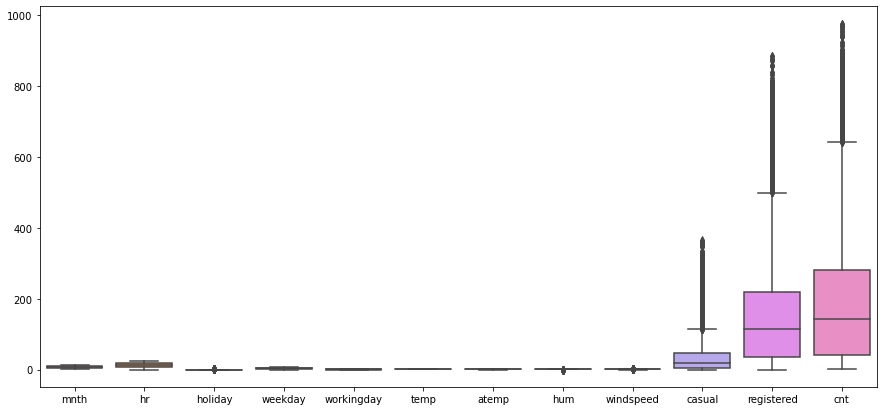

In [9]:
plt.figure(figsize=(15,7))
sns.boxplot(data=df[numerical_columns])
plt.show()

In [10]:
# нормализуем
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,0.0,0.000000,0.0,1.0,0.0,1,0.224490,0.2879,0.81,0.0,0.008174,0.014673,0.015369
1,1,0,0.0,0.043478,0.0,1.0,0.0,1,0.204082,0.2727,0.80,0.0,0.021798,0.036117,0.039959
2,1,0,0.0,0.086957,0.0,1.0,0.0,1,0.204082,0.2727,0.80,0.0,0.013624,0.030474,0.031762
3,1,0,0.0,0.130435,0.0,1.0,0.0,1,0.224490,0.2879,0.75,0.0,0.008174,0.011287,0.012295
4,1,0,0.0,0.173913,0.0,1.0,0.0,1,0.224490,0.2879,0.75,0.0,0.000000,0.001129,0.000000


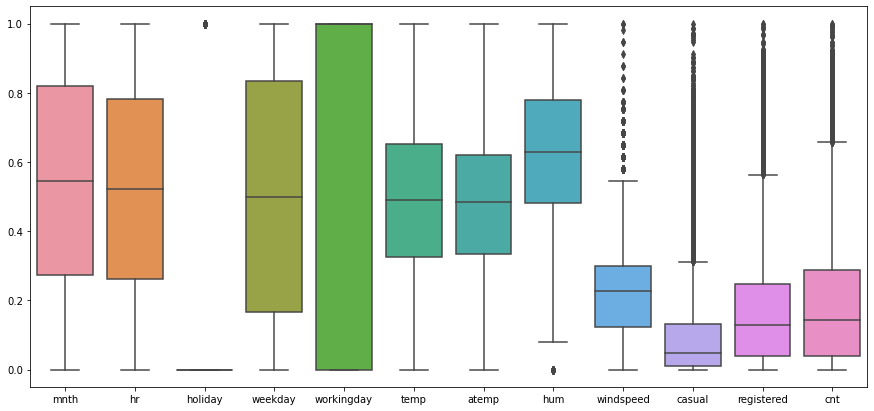

In [11]:
plt.figure(figsize=(15,7))
sns.boxplot(data=df[numerical_columns])
plt.show()

### 4) Выполните замену категориальных признаков

In [12]:
# выведем уникальные значения 
for i in categorial_columns:
    print(i,': ', df[i].unique())

season :  ['1' '2' '3' '4']
yr :  ['0' '1']
weathersit :  ['1' '2' '3' '4']


In [13]:
#Заменим значения в столбце "год" из строки на число
df['yr'] = df['yr'].apply(lambda x: int(x))

# выделим небинарные признаки
nonbinary_columns = [i for i in categorial_columns if len(df[i].unique()) > 2]
        
# для не бинарых применим dummy-кодирование
df_nonbinary = pd.get_dummies(df[nonbinary_columns])
df.drop(nonbinary_columns, axis=1, inplace=True)
df = pd.concat([df_nonbinary, df] , axis=1)

print(df.shape)
df.head()

(17377, 21)


,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,yr,mnth,...,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,0,0,1,0,0,0,0,0.0,...,0.0,1.0,0.0,0.224490,0.2879,0.81,0.0,0.008174,0.014673,0.015369
1,1,0,0,0,1,0,0,0,0,0.0,...,0.0,1.0,0.0,0.204082,0.2727,0.80,0.0,0.021798,0.036117,0.039959
2,1,0,0,0,1,0,0,0,0,0.0,...,0.0,1.0,0.0,0.204082,0.2727,0.80,0.0,0.013624,0.030474,0.031762
3,1,0,0,0,1,0,0,0,0,0.0,...,0.0,1.0,0.0,0.224490,0.2879,0.75,0.0,0.008174,0.011287,0.012295
4,1,0,0,0,1,0,0,0,0,0.0,...,0.0,1.0,0.0,0.224490,0.2879,0.75,0.0,0.000000,0.001129,0.000000


### 6) Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации)

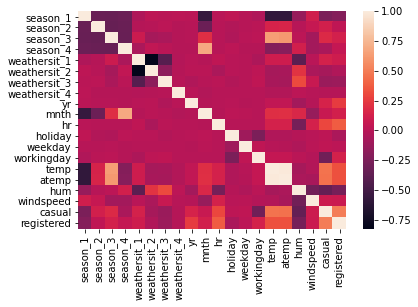

In [14]:
df_corr = df.drop('cnt', axis=1).corr()
sns.heatmap(df_corr)
plt.show()

In [15]:
df_corr

,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered
season_1,1.000000,-0.331363,-0.335694,-0.322400,-0.034028,0.029186,0.011056,0.023123,0.011290,-0.564829,0.008302,0.033612,0.001460,-0.029415,-0.583927,-0.587535,-0.135107,0.116125,-0.246534,-0.213944
season_2,-0.331363,1.000000,-0.344435,-0.330794,-0.010102,-0.002688,0.022197,-0.007662,-0.002590,-0.319354,-0.002983,-0.024416,-0.003477,0.015854,0.144360,0.151899,-0.000586,0.063399,0.123942,0.032283
season_3,-0.335694,-0.344435,1.000000,-0.335118,0.090574,-0.068308,-0.047058,-0.007762,-0.001054,0.197974,-0.003270,-0.026207,0.008777,0.020069,0.642494,0.619549,0.018088,-0.089313,0.175135,0.124756
season_4,-0.322400,-0.330794,-0.335118,1.000000,-0.048115,0.043210,0.014443,-0.007455,-0.007599,0.687117,-0.001949,0.017853,-0.006892,-0.007110,-0.217475,-0.198097,0.117364,-0.089378,-0.057605,0.054109
weathersit_1,-0.034028,-0.010102,0.090574,-0.048115,1.000000,-0.822953,-0.412403,-0.018173,0.007824,-0.010492,0.037081,0.009181,-0.003185,-0.041605,0.101075,0.101535,-0.383498,0.005214,0.136664,0.096379
weathersit_2,0.029186,-0.002688,-0.068308,0.043210,-0.822953,1.000000,-0.177442,-0.007819,0.011095,0.014087,-0.050623,0.004898,0.002075,0.024936,-0.069680,-0.066449,0.220810,-0.049295,-0.073438,-0.032370
weathersit_3,0.011056,0.022197,-0.047058,0.014443,-0.412403,-0.177442,1.000000,-0.003918,-0.031578,-0.003399,0.016932,-0.023671,0.002089,0.032144,-0.062419,-0.068359,0.309768,0.069995,-0.118689,-0.114823
weathersit_4,0.023123,-0.007662,-0.007762,-0.007455,-0.018173,-0.007819,-0.003918,1.000000,0.004313,-0.021161,0.000226,-0.002262,0.002160,-0.000454,-0.021178,-0.022090,0.017444,0.001492,-0.008799,-0.007131
yr,0.011290,-0.002590,-0.001054,-0.007599,0.007824,0.011095,-0.031578,0.004313,1.000000,-0.010390,-0.003851,0.006692,-0.004370,-0.002320,0.040793,0.039109,-0.083607,-0.008734,0.142792,0.253713
mnth,-0.564829,-0.319354,0.197974,0.687117,-0.010492,0.014087,-0.003399,-0.021161,-0.010390,1.000000,-0.005691,0.018449,0.010269,-0.003349,0.201836,0.208235,0.164410,-0.135330,0.068534,0.122383


Видна сильная отрицательная зависимость между параметрами, которые были выделены dummy-кодированием, что естественно. Есть слабая зависимость между casual(Число новых клиентов) и temp(относительная температура), что нормально. 

Никакие признаки не требуют удаления.

### 6)   Заполните пропущенные значения в данных

In [16]:
df.shape

(17377, 21)

In [17]:
df.count()

season_1        17377
season_2        17377
season_3        17377
season_4        17377
weathersit_1    17377
weathersit_2    17377
weathersit_3    17377
weathersit_4    17377
yr              17377
mnth            17377
hr              17377
holiday         17377
weekday         17377
workingday      17377
temp            17377
atemp           17377
hum             17377
windspeed       17377
casual          17377
registered      17377
cnt             17377
dtype: int64

Пропущенных значений нет

### 7)	Решите поставленную задачу регрессии в соответствии с заданием

- Линейная регрессия без использования регуляризаторов
- Линейная регрессия, RIDGE регуляризатор

In [18]:
# разделим полученные данные на данные для обучения и теста
X, y = df.drop('cnt', axis=1), df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(12163, 20)
(5214, 20)


#### Линейная регрессия без использования регуляризаторов

In [19]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
pred_regr = regr.predict(X_test)
print(y_test[:len(y_test)] - pred_regr[:len(y_test)])

13732    7.216450e-16
11772   -8.881784e-16
10484    1.526557e-15
12230   -1.332268e-15
431      1.469311e-15
             ...     
16661   -1.290634e-15
16721   -5.551115e-16
12847   -6.661338e-16
10213    1.304512e-15
16625   -1.110223e-15
Name: cnt, Length: 5214, dtype: float64


Разница между предсказанным и реальным количествами арендованных велосипедов очень мала, значит алгоритм линейной регрессии достаточно точно предсказывает количество арендованных велосипедов.  

In [20]:
corr = {}
corr['pearson'], _ = pearsonr(pred_regr, y_test)
corr['spearman'], _ = spearmanr(pred_regr, y_test)
print('pearson correlation: ', corr['pearson'])
print('spearmen correlation: ', corr['spearman'])

pearson correlation:  0.999999999999998
spearmen correlation:  0.9999872967483315


Корелляция Пирсона и Спирмена между предсказанным и реальным количеством аренд стремится к 1, эти велечины так же показывают высокую точность алгоритма.

#### Линейная регрессия, RIDGE регуляризатор

In [21]:
import warnings
warnings.filterwarnings("ignore")

regr = linear_model.Ridge()
params = {'alpha': np.arange(0, 3, 0.05)}
regr_grid = GridSearchCV(regr, params)
regr_grid.fit(X_train, y_train)
best_alpha = regr_grid.best_estimator_.alpha
print('best alpha:', best_alpha)

best alpha: 0.0


In [22]:
regr = linear_model.Ridge(alpha=best_alpha)
regr.fit(X_train,y_train)
pred_regr = regr.predict(X_test)
print(y_test[:len(y_test)] - pred_regr[:len(y_test)])

13732    2.220446e-16
11772   -1.887379e-15
10484    2.442491e-15
12230   -1.776357e-15
431      2.263814e-15
             ...     
16661   -4.302114e-16
16721   -6.106227e-16
12847    1.110223e-16
10213    2.303713e-15
16625   -2.220446e-16
Name: cnt, Length: 5214, dtype: float64


При использовании регуляризации разница между предсказанным и реальным количеством арен ещё больше уменьшается. Это значит, что точность алгоритма ещё больше повышается.

In [23]:
corr = {}
corr['pearson'], _ = pearsonr(pred_regr, y_test)
corr['spearman'], _ = spearmanr(pred_regr, y_test)
print('pearson correlation: ', corr['pearson'])
print('spearmen correlation: ', corr['spearman'])

pearson correlation:  0.9999999999999978
spearmen correlation:  0.999987316134776


Корреляция Пирсона уменьшилась на 0,0000000000000002 , а корреляция Спирмена увеличилась на 0,0000000193864445. Это также означает, что точность алгоритма повышается.